# **Accessible Spam Message Classifier with Auditory Feedback**

## **Problem Statement**
The goal of this project is to develop an intelligent system that automatically classifies text messages as spam or ham (not spam), with a particular focus on enhancing accessibility for elderly users and individuals with visual impairments. Spam messages can pose significant risks such as phishing, scams, and misinformation, which disproportionately affect these vulnerable groups. Therefore, our system aims not only to detect spam accurately but also to present the results in a clear, accessible way — including the option for the outcome to be read aloud, ensuring that users with limited vision or reading ability can easily understand the classification result.

To achieve this, the project employs **Natural Language Processing (NLP)** and machine learning techniques to analyze and classify text messages. The [<u>dataset</u>](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset?resource=download) contains labeled SMS messages categorized as spam or ham. Each message is preprocessed through text-cleaning steps like tokenization, stopword removal, and lemmatization, then converted into numerical features using TF-IDF (Term Frequency–Inverse Document Frequency). A **Support Vector Machine (SVM)** model is trained on these features to learn how to distinguish spam messages from legitimate ones. The system’s performance is evaluated using accuracy, precision, recall, and confusion matrix metrics. Finally, the model is deployed within a Streamlit [<u>application</u>](https://spammsgcheck.streamlit.app/) with auditory feedback.

## **Workflow Summary**
A dataset from Kaggle is used to develop an accessible spam message classifier based on an SVM model. Users can receive auditory feedback by simply pasting or entering a text message into the web application.

1. Import required libraries
2. Analyze the data distribution and perform initial preprocessing
3. Clean the text data by removing stop words and transforming words into their root form
4. Stratify the dataset into training (80%) and testing (20%) sets on the same class ratio
5. Further divide the training data set into validation set for tuning hyperparameters of the model
6. Convert the text data of training and validation sets into numerical features using TfidfVectorizer, which assigns weights based on the importance of each word
7. Train the optimal SVM model with training data and search for the best parameters c and gamma which achieved the highest F1 score on the validation data set
8. Save the model and vectorizer to the [<u>GitHub repository</u>](https://github.com/cckmwong-data/spam_msg_app) for deployment in the Streamlit [<u>application</u>](https://spammsgcheck.streamlit.app/)

### **(1) Import Libaries**

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import nltk
import string
import re
import tkinter as tk
from tkinter import messagebox
import matplotlib.pyplot as plt
import joblib

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [ ]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### **(2) Define Customer Functions**
In this section, we define various custom functions to handle data preprocessing and model training.

In [ ]:
# Function for converting the message into tokens or individual words
def text_processing(text):

    #text = text.lower() #change the text to lower case
    text = re.sub(r"@\S+|https?:\S+|http?:\S+|\S+@\S+", ' ', str(text).lower())
    text = re.sub(r"[^a-z\s]", ' ', text)
    textList = []
    text = nltk.word_tokenize(text) #divide the whole message into bite-sized tokens or individual words
    for i in text:
        #check if each of the token is either alphabet or numbers. If yes, store the useful bits into the list
        if i.isalnum():
            textList.append(i)
    return textList

In [ ]:
# Function to remove stopwords, words that are commonly used in English
def remove_stopwords(text):
    textList = [] #create a new list
    for i in text:
        #Check if the token is not a stop word AND is not punctuation
        if i not in nltk.corpus.stopwords.words('english') and i not in string.punctuation:
            textList.append(i) #append individual tokens into a list
    return textList

In [ ]:
# Function to reduce words to their root form
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    textList = []
    for i in text:
        textList.append(lemmatizer.lemmatize(i))
    return textList

In [ ]:
# Function to train the SVM model using the parameters c and gamma which acheived the highest model accuracy
def modeling(x_train, x_test, y_train, y_test):
    #possible values for the paramters
    parameters = {'gamma': [0.01, 0.001, 0.0001, 0.00001, 0.000001],
                  'C': [1, 10, 100, 1000, 10000, 100000]}
    grid = list(ParameterGrid(parameters)) #calculate all the possible combinations of parameters

    # further divide the training data set into validation set (20%) for tuning parameters of the model
    x_tr, x_val, y_tr, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    # TfidfVectorizer is to convert text data into numerical features
    TVect = TfidfVectorizer()
    x_tr_trans = TVect.fit_transform(x_tr) #fit and transform x_train data into numerical features
    X_val_trans = TVect.transform(x_val)

    best_f1 = 0 # pick the hyperparameters by f1 due to data imbalance
    best_parameter = None

    # searching for the best parameters by maximizing the accuracy of the model
    for p in grid:
        clf = SVC(C=p['C'], gamma=p['gamma'], class_weight='balanced')
        clf.fit(x_tr_trans, y_tr) #fitting the model using the training data
        predictions = clf.predict(X_val_trans) #making prediction using validation data
        f1 = f1_score(y_val, predictions) #accuracy
        if f1 > best_f1:
            best_f1 = f1
            best_parameter = p

    X_train_full_trans = TVect.fit_transform(x_train)
    x_test_trans = TVect.transform(x_test) #transform x_test data into numerical features

    # create a new SVM model with the best parameters
    best_model = SVC(C=best_parameter['C'], gamma=best_parameter['gamma'], class_weight='balanced')
    best_model.fit(X_train_full_trans, y_train) # fitting the model
    best_predictions = best_model.predict(x_test_trans) # predictions from the best model

    # F1 of the model
    print('F1 of the model: %.2f' % f1_score(y_test, best_predictions))

    # find the confusion matrix
    print(confusion_matrix(y_test, best_predictions))

    # print the precision and recall in classification report
    print("Classification Report:\n", classification_report(y_test, best_predictions))

    return best_model, TVect

In [ ]:
# Function for predicting whether or not the input message is SPAM
def predict_message(model, vectorizer, message):
    #Preprocess the input message
    message = text_processing(message) #change the message into tokens
    message = remove_stopwords(message) #remove stopwords
    message = lemmatize_text(message) #transform words into their base-words

    #Convert to one whole string
    message = ' '.join(message)

    #Transform the message using the same TF-IDF vectorizer as that of training the SVM model
    message_transformed = vectorizer.transform([message])

    #Predict using trained model
    prediction = model.predict(message_transformed)[0]

    #Decode the label to SPAM or NOT SPAM
    result = "SPAM" if prediction == 1 else "NOT SPAM"
    return result

### **(3) Exploratory Data Analysis**
We analyze the distribution of message categories in the dataset. A bar chart is plotted to visualize the number of ham (not spam) and spam messages, providing an overview of class balance. The categorical labels are converted from text values (ham and spam) to numerical form (0 for ham and 1 for spam) to facilitate model training, followed by the removal of duplicates.

In [ ]:
# download the dataset which contains thousands rows of SPAM and NOT SPAM messages
df = pd.read_csv('https://raw.githubusercontent.com/cckmwong-data/spam_msg_app/refs/heads/main/dataset/spam1.csv')

In [ ]:
df

,Category,Message
0,ham,"Hmm well, night night"
1,ham,"Yup. Anything lor, if u dun wan it's ok..."
2,ham,Or Ã¼ go buy wif him then i meet Ã¼ later can?
3,ham,And you! Will expect you whenever you text! Ho...
4,ham,Love it! Daddy will make you scream with pleas...
...,...,...
5800,ham,At the funeral home with Audrey and dad
5801,ham,I'm at home. Please call
5802,ham,"As I entered my cabin my PA said, '' Happy B'd..."
5803,ham,aathi..where are you dear..


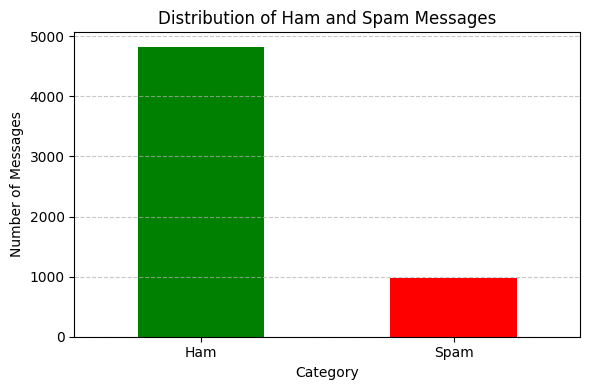

In [ ]:
# Count ham (0) and spam (1) messages
label_counts = df['Category'].value_counts()

# Bar plot
plt.figure(figsize=(6,4))
label_counts.plot(kind='bar', color=['green', 'red'])
plt.title("Distribution of Ham and Spam Messages")
plt.xticks([0, 1], ['Ham', 'Spam'], rotation=0)
plt.ylabel("Number of Messages")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# change the categories of ham and spam to 0 and 1 respectively
df.loc[df['Category'] == 'ham', 'Category'] = 0
df.loc[df['Category'] == 'spam', 'Category'] = 1

In [ ]:
df

,Category,Message
0,0,"Hmm well, night night"
1,0,"Yup. Anything lor, if u dun wan it's ok..."
2,0,Or Ã¼ go buy wif him then i meet Ã¼ later can?
3,0,And you! Will expect you whenever you text! Ho...
4,0,Love it! Daddy will make you scream with pleas...
...,...,...
5800,0,At the funeral home with Audrey and dad
5801,0,I'm at home. Please call
5802,0,"As I entered my cabin my PA said, '' Happy B'd..."
5803,0,aathi..where are you dear..


In [ ]:
df = df.drop_duplicates().reset_index(drop=True) #remove duplicates

### **(4) Data Cleaning**
To enhance model accuracy and interpretability, data cleaning is performed by removing stop words from the messages and transforming words into their root form through lemmatization.

In [ ]:
# tokenize every message of the dataset
df['Message'] = df['Message'].apply(text_processing)
df

,Category,Message
0,0,"[hmm, well, night, night]"
1,0,"[yup, anything, lor, if, u, dun, wan, it, s, ok]"
2,0,"[or, go, buy, wif, him, then, i, meet, later, ..."
3,0,"[and, you, will, expect, you, whenever, you, t..."
4,0,"[love, it, daddy, will, make, you, scream, wit..."
...,...,...
5256,0,"[dont, worry, day, very, big, lambu, ji, vl, c..."
5257,0,"[then, wat, r, u, doing, now, busy, wif, work]"
5258,0,"[cool, text, me, when, you, re, parked]"
5259,0,"[at, the, funeral, home, with, audrey, and, dad]"


In [ ]:
# remove stopwords of the messages in the dataset
df['Message'] = df['Message'].apply(remove_stopwords)

In [ ]:
# transform the words into their base-form
df['Message'] = df['Message'].apply(lemmatize_text)

In [ ]:
df

,Category,Message
0,0,"[hmm, well, night, night]"
1,0,"[yup, anything, lor, u, dun, wan, ok]"
2,0,"[go, buy, wif, meet, later]"
3,0,"[expect, whenever, text, hope, go, well, tomo]"
4,0,"[love, daddy, make, scream, pleasure, going, s..."
...,...,...
5256,0,"[dont, worry, day, big, lambu, ji, vl, come, t..."
5257,0,"[wat, r, u, busy, wif, work]"
5258,0,"[cool, text, parked]"
5259,0,"[funeral, home, audrey, dad]"


In [ ]:
word_list = pd.DataFrame()
word_list = df.copy() #copy the tokenized message to a new dataframe for the use of finding top 10 most frequent words in SPAM msg later on

In [ ]:
# Join tokens into a single string
df['Message'] = df['Message'].apply(lambda x: ' '.join(x))

### **(5) Modeling of Support Vector Machine (SVM)**
We observe a class imbalance between spam and ham categories. To address this, the dataset is stratified into training (80%) and testing (20%) sets, ensuring the same class ratio in both. To prevent data leakage, the training data is further divided into a validation set for model parameter tuning. During training, a TfidfVectorizer is employed to convert text messages into a numerical feature matrix interpretable by the SVM model. This method assigns weights to words based on their importance, taking into account both their frequency and their uniqueness across the dataset. The optimal model is then selected based on the highest F1 score achieved on the validation set.

In [ ]:
x = df['Message']
y = df['Category'].astype(int)

In [ ]:
# split the dataset into training and test data at the same class proportion
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# finding the best SVM model
# return the same TfidfVectorizer for the later conversion of the user's text message
best_model, TVect = modeling(x_train, x_test, y_train, y_test)

F1 of the model: 0.92
[[897   7]
 [ 16 133]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       904
           1       0.95      0.89      0.92       149

    accuracy                           0.98      1053
   macro avg       0.97      0.94      0.95      1053
weighted avg       0.98      0.98      0.98      1053



### **(6) Save Model and Vectorizer**
Finally, the trained SVM model and the corresponding vectorizer are saved to the [GitHub repository](https://github.com/cckmwong-data/spam_msg_app) for deployment in the Streamlit [application](https://spammsgcheck.streamlit.app/).

In [ ]:
import joblib

# After training
joblib.dump(best_model, 'svm_spam_model.pkl')

['svm_spam_model.pkl']

In [ ]:
joblib.dump(TVect, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']